In [9]:
import geopandas as gpd 
import pandas as pd 
training_data = gpd.read_file('../results/agri_points_with_labels.geojson')

In [10]:
training_data.columns

Index(['long', 'lat', 'boron', 'nitrogen', 'phos', 'potas', 'pH', 'zinc',
       'clay', 'OM', 'Sand', 'Silt', 'Rainfall', 'Temp', 'Elevation', 'Slope',
       'nearest_rainfall', 'Water', 'Road', 'LULC_Code', 'class',
       'class_level_1', 'class_level_2', 'geometry'],
      dtype='object')

In [11]:
features = ['long', 'lat', 'boron', 'nitrogen', 'phos', 'potas', 'pH',
            'zinc', 'clay', 'OM', 'Sand', 'Silt', 'Rainfall', 'Temp', 'Elevation',
            'Slope', 'Water', 'Road', 'LULC_Code']

In [12]:
target = 'class_level_2'

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np 
import matplotlib.pyplot as plt

training_data_clean = training_data.dropna(subset=[target])

X = training_data_clean[features].values
y = training_data_clean[target].values
labels = training_data_clean[target].unique()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print(f"\nTrain distribution:\n{pd.Series(y_train).value_counts()}")
print(f"\nTest distribution:\n{pd.Series(y_test).value_counts()}")

Train size: 2765, Test size: 692

Train distribution:
not_suitable             1701
very_low_suitability      351
high_suitability          272
low_suitability           225
very_high_suitability     132
moderate_suitability       84
Name: count, dtype: int64

Test distribution:
not_suitable             426
very_low_suitability      88
high_suitability          68
low_suitability           56
very_high_suitability     33
moderate_suitability      21
Name: count, dtype: int64


In [14]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc


def train_classifier(clf, param_grid, X_train, y_train, X_test, y_test, model_name):
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])
    param_grid = {f'classifier__{key}': value for key, value in param_grid.items()}
    
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5, 
        scoring='f1_macro', 
        n_jobs=-1, 
        verbose=1,
        return_train_score=True,
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nBest hyper param: {grid_search.best_params_}")
    print(f"Training F1-macro score: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]:.4f}")
    print(f"Validation F1-macro score: {grid_search.cv_results_['mean_test_score'][grid_search.best_index_]:.4f}")
    
    best_params = grid_search.best_params_
    
    best_model = pipeline.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"Test F1-macro score: {f1_macro:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, cmap=plt.cm.Blues, 
                                                                colorbar=False, xticks_rotation=90)
    ax.set_title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    macro_roc_auc = roc_auc_score(
        y_test,
        y_pred_proba,
        multi_class="ovr",
        average="macro",
    )
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    n_classes = len(labels)
    
    fpr = dict()
    tpr = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)
    
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])
    
    mean_tpr /= n_classes
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr_grid, mean_tpr, 
            label=f'Macro-average ROC (AUC = {macro_roc_auc:.2f})',
            color='navy', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance level (AUC = 0.5)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - One-vs-Rest ROC (Macro Average)')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    
    results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=5, scoring='f1_macro')
    
    # print(results)
    importance = pd.Series(
        results.importances_mean, index=features
    ).sort_values(ascending=True)
    
    ax = importance.plot.barh()
    ax.set_title(f"{model_name} Permutation Feature Importances")
    ax.figure.tight_layout()
    
    return best_model, best_params, f1_macro

Train random forest 

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best hyper param: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Training F1-macro score: 0.9406
Validation F1-macro score: 0.6327
Test F1-macro score: 0.6499

Classification Report:
                       precision    recall  f1-score   support

     high_suitability       0.29      0.40      0.34        68
      low_suitability       0.95      0.75      0.84        56
 moderate_suitability       0.41      0.33      0.37        21
         not_suitable       0.87      0.84      0.85       426
very_high_suitability       0.50      0.55      0.52        33
 very_low_suitability       0.97      1.00      0.98        88

             accuracy                           0.78       692
            macro avg       0.66      0.64      0.65       692
         weighted avg       0.80      0.78      0.79       692



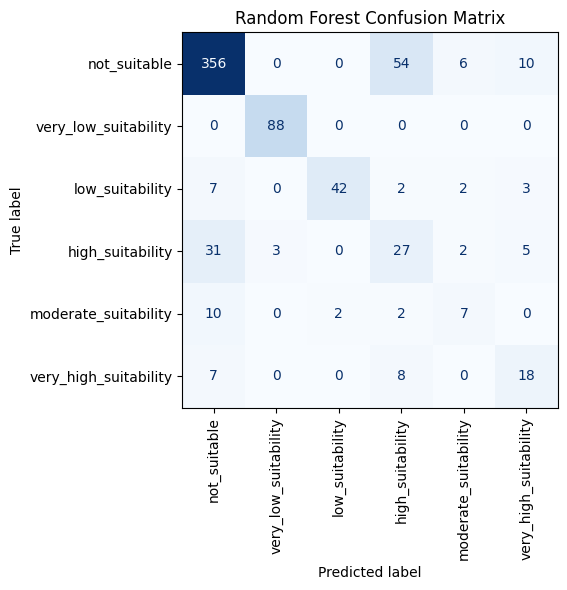

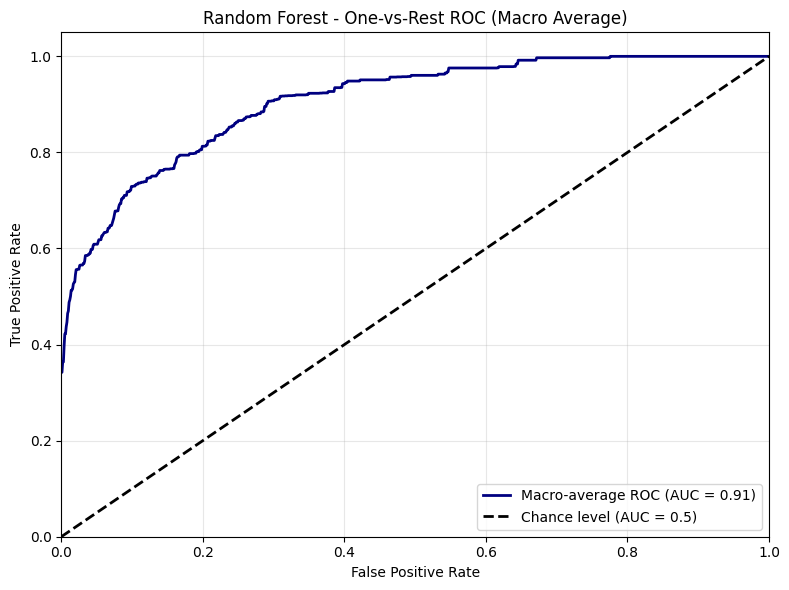

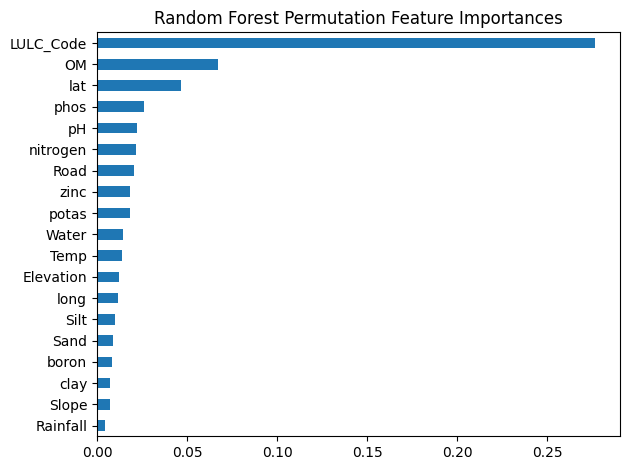

In [15]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    # 'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rf_clf = RandomForestClassifier(random_state=5)

rf_model, rf_best_params , rf_test_score = train_classifier(
    rf_clf, 
    rf_param_grid, 
    X_train, y_train, 
    X_test, y_test, 
    model_name='Random Forest',
)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best hyper param: {'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Training F1-macro score: 0.8809
Validation F1-macro score: 0.5903
Test F1-macro score: 0.5955

Classification Report:
                       precision    recall  f1-score   support

     high_suitability       0.36      0.22      0.27        68
      low_suitability       0.78      0.75      0.76        56
 moderate_suitability       0.21      0.14      0.17        21
         not_suitable       0.84      0.92      0.87       426
very_high_suitability       0.58      0.45      0.51        33
 very_low_suitability       0.98      0.99      0.98        88

             accuracy                           0.80       692
            macro avg       0.62      0.58      0.60       692
         weighted avg       0.77      0.80      0.78       692



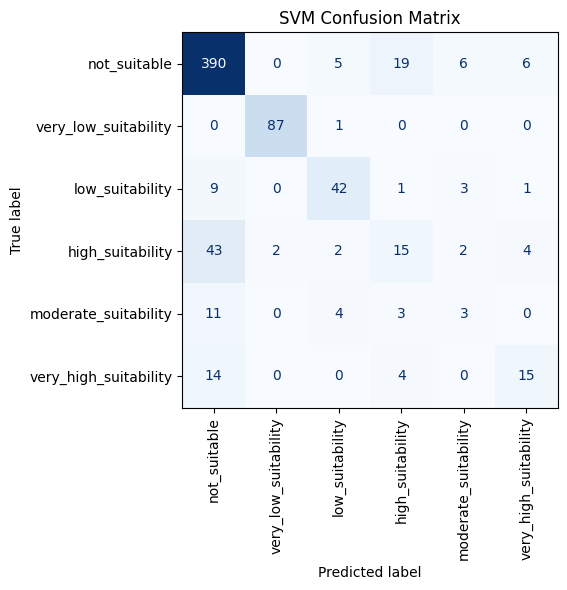

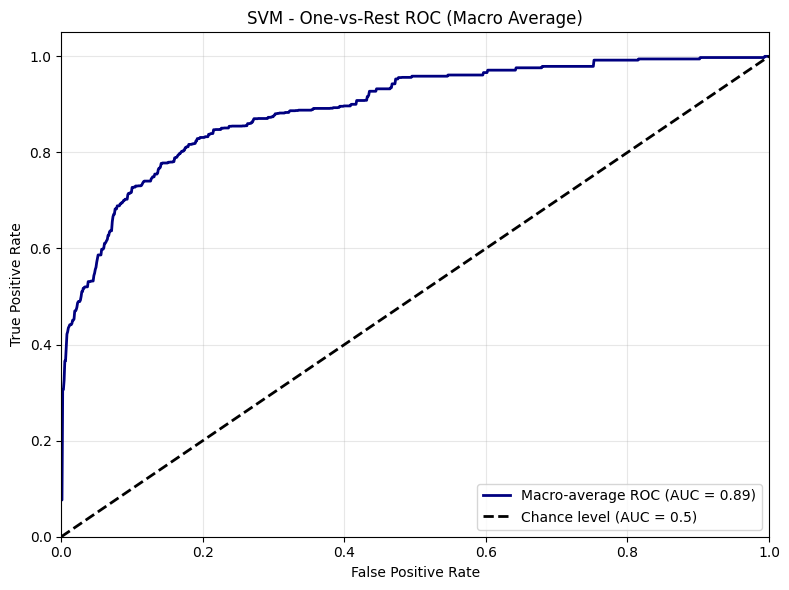

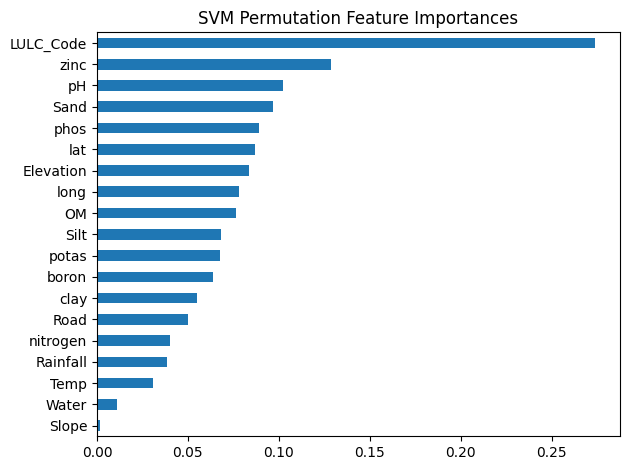

In [16]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100, 200],
    # 'gamma' : ['scale', 'auto'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 0.3],
    # 'kernel': ['rbf', 'poly', 'sigmoid']
    'kernel': ['rbf','sigmoid']
    
}

svm_clf = SVC(random_state=5,probability=True)


svm_model, svm_best_params, svm_test_score = train_classifier(
    svm_clf, 
    svm_param_grid, 
    X_train, y_train, 
    X_test, y_test, 
    "SVM",)

In [17]:
from sklearn.dummy import DummyClassifier

def get_dummy_f1_scores(X_train, y_train, X_test, y_test, random_state=5):
    results = {}
    for strategy in ['most_frequent', 'stratified', 'uniform']:
        dummy = DummyClassifier(strategy=strategy, random_state=random_state)
        dummy.fit(X_train, y_train)
        y_pred = dummy.predict(X_test)
        score = f1_score(y_test, y_pred, average='macro')
        results[f'Dummy ({strategy})'] = {
            'test_score': score
        }
    return results

In [18]:
dummy_results = get_dummy_f1_scores(X_train, y_train, X_test, y_test)

In [19]:
dummy_results

{'Dummy (most_frequent)': {'test_score': 0.12701252236135957},
 'Dummy (stratified)': {'test_score': 0.17165917051352622},
 'Dummy (uniform)': {'test_score': 0.13314195589545458}}

In [20]:
dummy_results['svm']= {'test_score': svm_test_score}
dummy_results['random_forest'] = {'test_score': rf_test_score}

In [21]:
dummy_results

{'Dummy (most_frequent)': {'test_score': 0.12701252236135957},
 'Dummy (stratified)': {'test_score': 0.17165917051352622},
 'Dummy (uniform)': {'test_score': 0.13314195589545458},
 'svm': {'test_score': 0.595462979646934},
 'random_forest': {'test_score': 0.6499102069932914}}

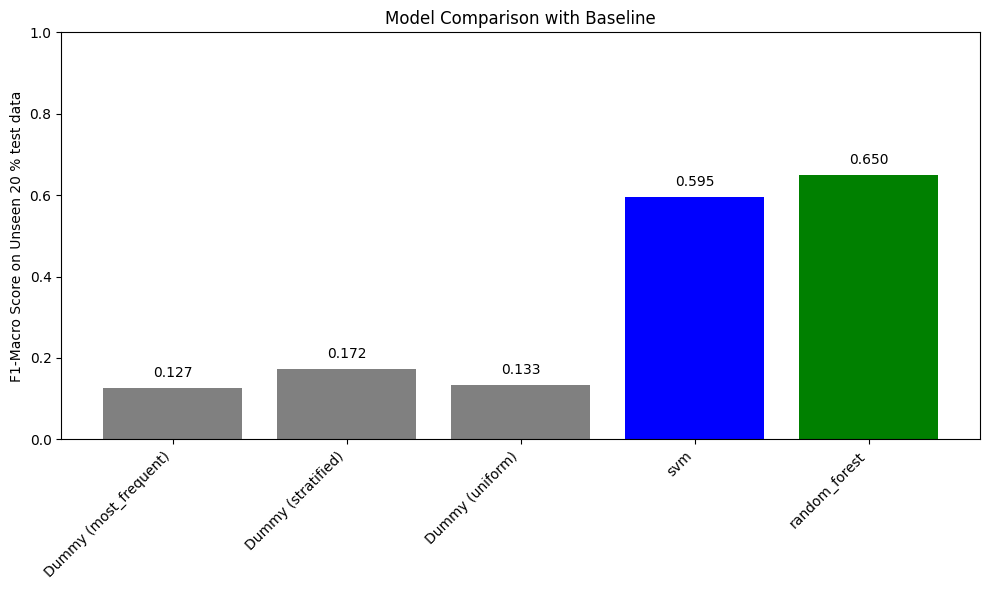

In [22]:
scores = {k: v['test_score'] for k, v in dummy_results.items()}

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(scores.keys(), scores.values(), color=['gray', 'gray', 'gray', 'blue', 'green'])
ax.set_ylabel('F1-Macro Score on Unseen 20 % test data')
ax.set_title('Model Comparison with Baseline')
ax.set_ylim([0, 1])
plt.xticks(rotation=45, ha='right')
for i, (name, score) in enumerate(scores.items()):
    ax.text(i, score + 0.02, f'{score:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()